In [18]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import pylatexenc

/opt/conda/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


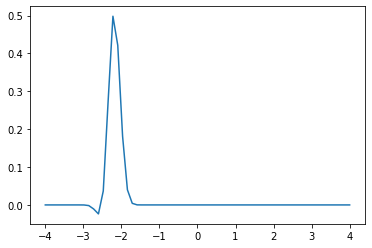

In [19]:
'''constants'''
n=6 #number of qubits
N=2**n #grid points
phi=0.1 #time step
iterations=30

'''potential'''
# V=0 #free particle
# V=1.75

'''spatial grid'''
xMin=-4
xMax=4
x = np.linspace(xMin,xMax, num=N)

'''wavefunction: guassian wavepacket'''
mu=-2.25
psi= (1/(np.sqrt(2*np.pi)*2*0.4)*np.exp(-(0.5*(x-mu)**2)/(2*0.016)))*np.exp(-300j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))
plt.plot(x,psi)

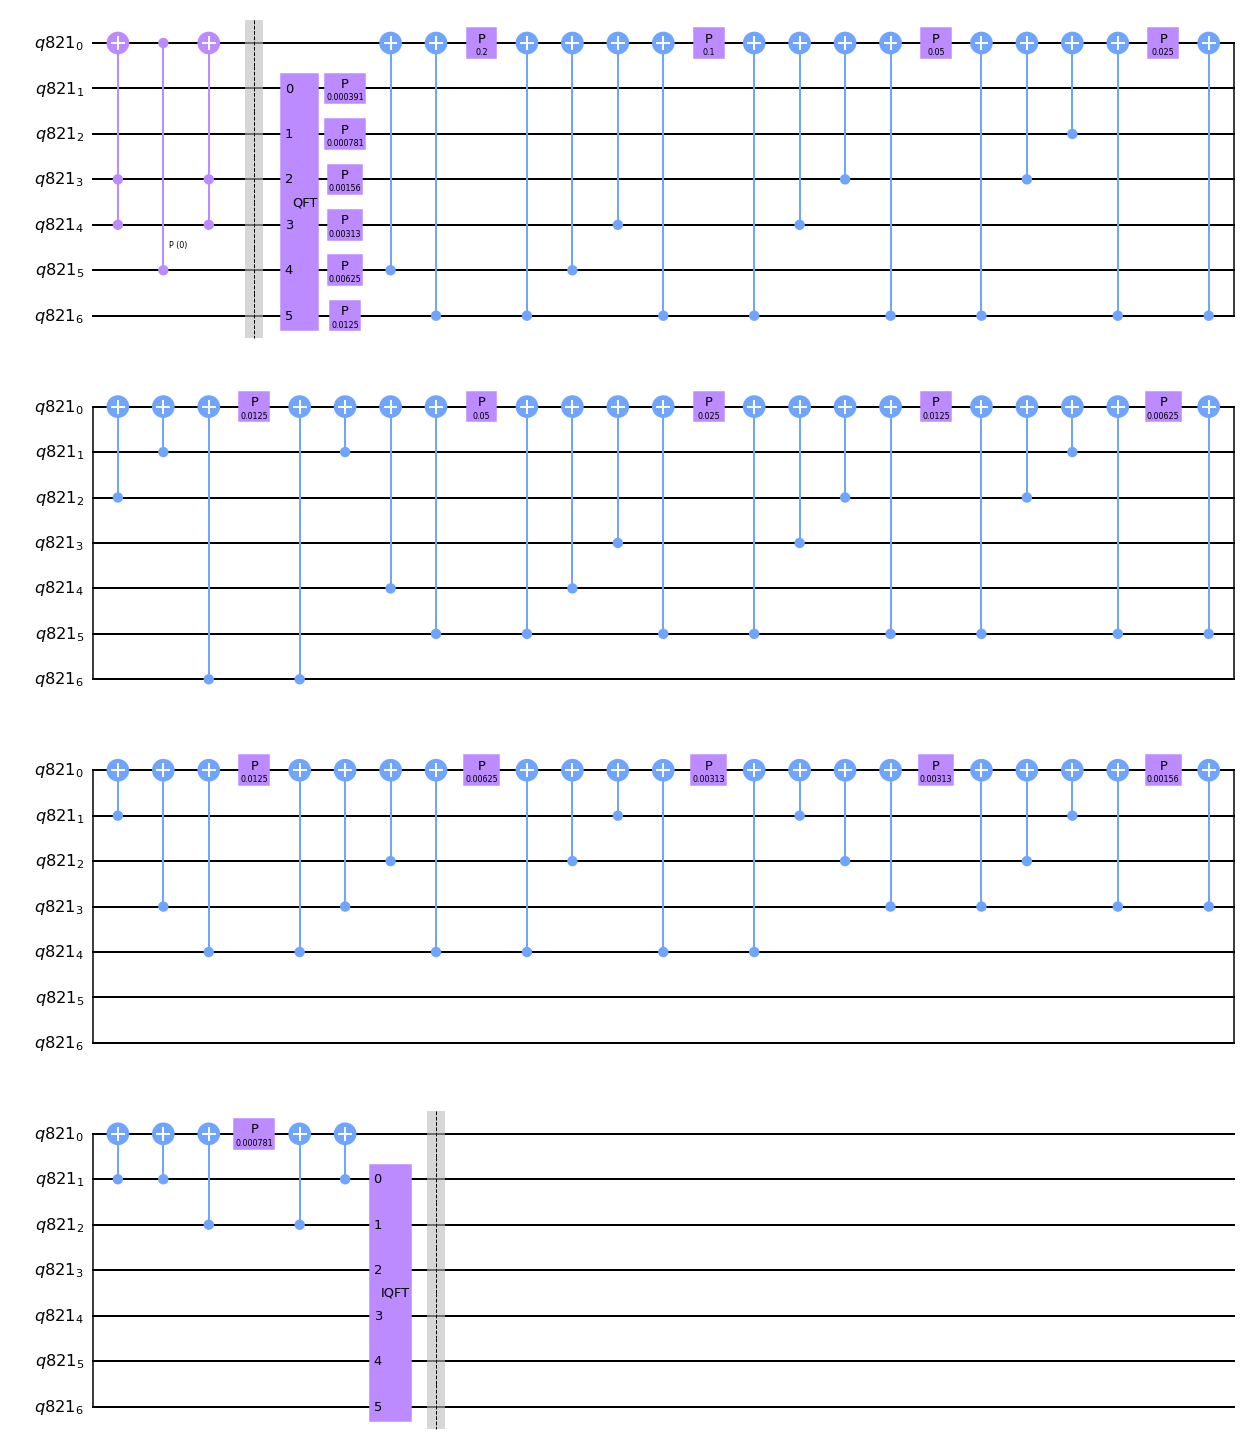

In [20]:
qubits=QuantumRegister(n+1)
splitOp=QuantumCircuit(qubits,name="splitOp")
'''potential operator''' 
splitOp.ccx(3,4,0)
splitOp.cp(V*phi,0,5)
splitOp.ccx(3,4,0)
splitOp.barrier()
'''momentum operator'''
splitOp.append(QFT(n),qubits[1:])
for i in range(n):
  splitOp.p(phi/2**(n-3+i), n-i)
for i in range(n):
  for j in range(i+1,n):
    splitOp.cx(n-j,0)
    splitOp.cx(n-i,0)
    splitOp.p(phi*(2**(2-i-j)),0)
    splitOp.cx(n-i,0)
    splitOp.cx(n-j,0)
splitOp.append(QFT(n,inverse=True),qubits[1:])
splitOp.barrier()
splitOp.draw('mpl')

In [21]:
q=QuantumRegister(n+1)
c=ClassicalRegister(n)
circuit=QuantumCircuit(q,c)
'''initialization'''
circuit.initialize(psi,q[1:])
circuit.barrier()
'''time steps'''
for i in range(iterations):
  circuit.append(splitOp,q[:])
'''measurement'''
for i in range(1,n+1):
  circuit.measure(i,i-1)
#circuit.draw('mpl')
answer = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=5000).result().get_counts()

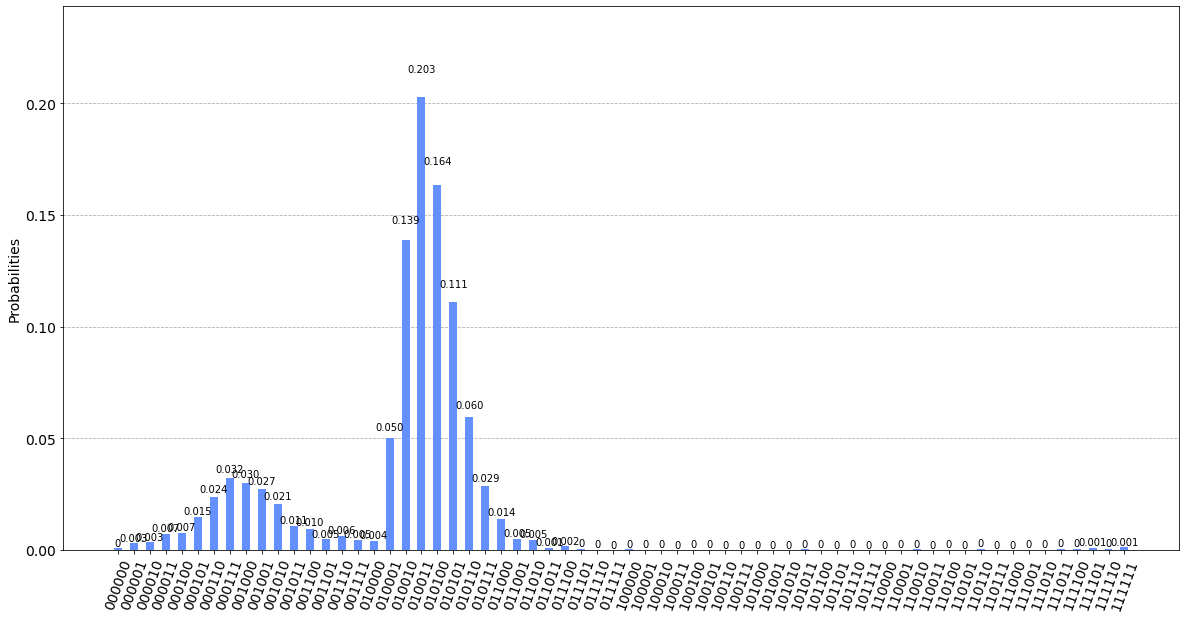

In [22]:
for a in range(N):
  s = bin(a)[2:]
  while len(s)!=6:
    s='0'+s
  if s not in answer.keys():
    answer[s] = 0
plot_histogram(answer, figsize = [20,10])

1.0000000000000002


/opt/conda/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


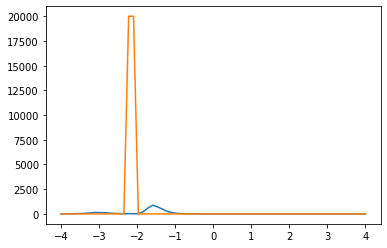

In [23]:
new_psi=np.zeros(N)
count=0
for key in sorted(answer.keys()):
  new_psi[count]=answer[key]
  count+=1
new_psi=new_psi/np.sqrt(np.sum(psi**2))
barrier=np.zeros(N)
barrier[14:16]=20000
print(np.sum(np.abs(psi**2)))
plt.plot(x,new_psi)
plt.plot(x,barrier)
plt.show()